In [1]:
import numpy as np
import torch
import argparse
import torch.nn as nn
from model.CNN import CNN

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

(280, 300, 3)

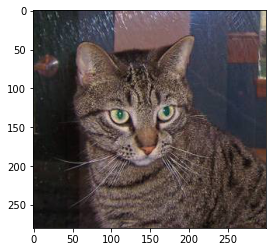

In [66]:
import matplotlib.image as img

file_name = 'datasets/training_set/training_set/cats/cat.1.jpg'
image = img.imread(file_name)
plt.imshow(image)

# height, width, channel
np.array(image).shape

In [5]:
ls datasets/training_set/training_set/cats/cat.1.jpg

datasets/training_set/training_set/cats/cat.1.jpg


In [6]:
import torch
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms

In [7]:
trans = transforms.Compose([transforms.Resize((100, 100)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root='./datasets/training_set/training_set', transform=trans)
train_size = int(0.8 * len(trainset))
test_size = int(len(trainset) - train_size)

trainset, valset = torch.utils.data.random_split(trainset, [train_size, test_size])
testset = torchvision.datasets.ImageFolder(root='./datasets/test_set/test_set', transform=trans)

In [8]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4) 

classes = ('cat', 'dog')
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0])


In [9]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

torch.Size([16, 3, 100, 100])
(3, 410, 410)
(410, 410, 3)
torch.Size([16, 3, 100, 100])
torch.Size([3, 206, 818])
  dog   dog   cat   cat   cat   dog   cat   cat   dog   dog   cat   cat   dog   dog   dog   cat 


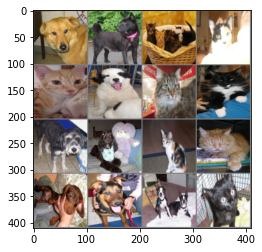

In [10]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

(3, 100, 100)
(100, 100, 3)
cat


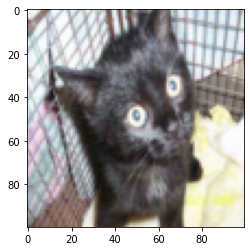

In [11]:
imshow(images[15])
print(classes[labels[15]])

In [12]:
from tqdm.notebook import tqdm

In [13]:
class CNN(nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*21*21, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        
    
    def forward(self, x):
        out = self.layer(x)
        out = out.view(x.size(0), -1)
        out = self.fc_layer(out)
        return out

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
labels[0]

tensor(1)

In [16]:
# Train
for epoch in tqdm(range(10)):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    train_loss = 0.0

    # Train
    model.train()
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        train_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    train_loss /= len(trainloader)
    # Validation
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # Validation Loss
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total

    print('Epoch {}, Train Loss: {:.2f}, Val Loss: {:.2f}, Val Acc: {:.2f}'.format(epoch, train_loss, val_loss, val_acc))

# Measure Test Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print('Test Acc: {}%'.format(test_acc))


Epoch 0, Train Loss: 0.66, Val Loss: 0.63, Val Acc: 65.83
Epoch 1, Train Loss: 0.59, Val Loss: 0.60, Val Acc: 68.71
Epoch 2, Train Loss: 0.54, Val Loss: 0.57, Val Acc: 70.27
Epoch 3, Train Loss: 0.49, Val Loss: 0.55, Val Acc: 72.58
Epoch 4, Train Loss: 0.46, Val Loss: 0.55, Val Acc: 71.71
Epoch 5, Train Loss: 0.41, Val Loss: 0.56, Val Acc: 72.83
Epoch 6, Train Loss: 0.37, Val Loss: 0.54, Val Acc: 74.20
Epoch 7, Train Loss: 0.33, Val Loss: 0.57, Val Acc: 74.33
Epoch 8, Train Loss: 0.28, Val Loss: 0.61, Val Acc: 74.20
Epoch 9, Train Loss: 0.23, Val Loss: 0.70, Val Acc: 72.08

Test Acc: 74.34503213049926%


In [17]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

In [75]:
sample = torchvision.datasets.ImageFolder(root='./ahri', transform=trans)
sampleloader = DataLoader(sample, batch_size=4, shuffle=False, num_workers=4) 
dataiter = iter(sampleloader)
images, labels = dataiter.next()

(3, 206, 206)
(206, 206, 3)
torch.Size([3, 104, 410])
  cat   cat   cat   cat 


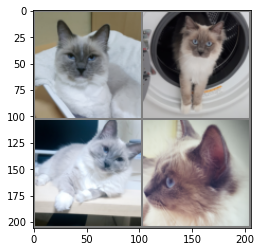

In [76]:
imshow(torchvision.utils.make_grid(images, nrow=2))
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(4)))

In [81]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
outputs

tensor([[ 1.1170, -2.5838],
        [-3.8063,  1.9612],
        [ 0.1412, -1.2400],
        [-1.2382,  0.3457]], device='cuda:0', grad_fn=<AddmmBackward>)

In [82]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   dog   cat   dog
